## Imports the libraries

In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
# from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## making the shape of the image (224,224,3)

In [2]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

## reading the images from folder

In [3]:
base_path = r"C:\Users\lamaa\Desktop\Detrash project\garbage_classification"
dir_list = os.listdir(base_path)

print("Files and directories in '", base_path, "' :")

# prints all files

print(dir_list)

Files and directories in ' C:\Users\lamaa\Desktop\Detrash project\garbage_classification ' :
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [4]:
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

## making the dataframe

In [5]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [6]:
filenames_list = []
categories_list = []

for category in dir_list:
    
    filenames = os.listdir(base_path+"/"+ category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
 })

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head(10)

,filename,category
0,clothes/clothes4362.jpg,clothes
1,clothes/clothes276.jpg,clothes
2,brown-glass/brown-glass427.jpg,brown-glass
3,shoes/shoes142.jpg,shoes
4,biological/biological437.jpg,biological
5,battery/battery198.jpg,battery
6,battery/battery147.jpg,battery
7,shoes/shoes1874.jpg,shoes
8,clothes/clothes1423.jpg,clothes
9,clothes/clothes3328.jpg,clothes


## Viusalize the Categories Distribution

Text(0.5, 1.02, 'Count of images per class')

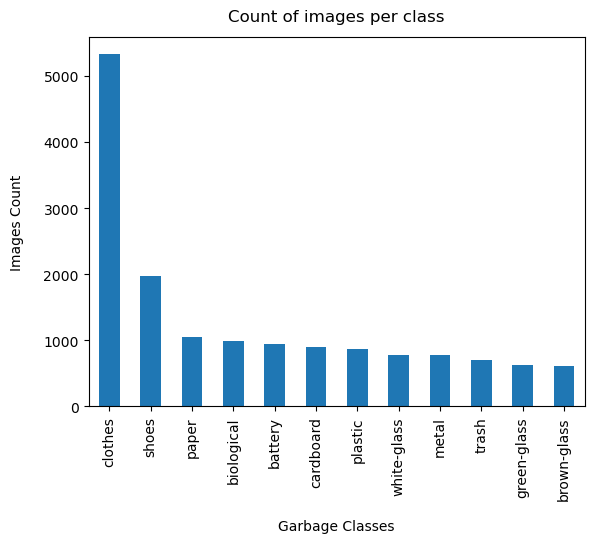

In [8]:
df['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02)

# creatin the model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

In [10]:
mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS))
#                        weights = 'imagenet')

In [11]:
# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
    return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
## We will use the EarlyStopping call back to stop our training if the
## validation_accuray is not improving for a certain number of epochs.
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [13]:

#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


## playing with images flip and zooming too

In [14]:
batch_size=64

train_datagen = image.ImageDataGenerator(
 
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
)

## training time

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    #shuffle = True, 
    class_mode = 'categorical'
)

Found 12412 validated image filenames belonging to 12 classes.


In [16]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    #shuffle = True,
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [17]:
train_df['category'].value_counts()

clothes        4235
shoes          1571
paper           860
biological      803
battery         760
cardboard       700
plastic         690
white-glass     620
metal           617
trash           559
green-glass     508
brown-glass     489
Name: category, dtype: int64

In [18]:
EPOCHS = 25
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\lamaa\AppData\Local\Temp\ipykernel_20212\2306379563.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
193/193 [==============================] - 529s 3s/step - loss: 0.7015 - categorical_accuracy: 0.7930 - val_loss: 0.3120 - val_categorical_accuracy: 0.9147
Epoch 2/25
193/193 [==============================] - 499s 3s/step - loss: 0.3421 - categorical_accuracy: 0.8948 - val_loss: 0.2572 - val_categorical_accuracy: 0.9258
Epoch 3/25
193/193 [==============================] - 456s 2s/step - loss: 0.2856 - categorical_accuracy: 0.9088 - val_loss: 0.2417 - val_categorical_accuracy: 0.9290
Epoch 4/25
193/193 [==============================] - 472s 2s/step - loss: 0.2731 - categorical_accuracy: 0.9149 - val_loss: 0.2242 - val_categorical_accuracy: 0.9316
Epoch 5/25
193/193 [==============================] - 479s 2s/step - loss: 0.2506 - categorical_accuracy: 0.9181 - val_loss: 0.2143 - val_categorical_accuracy: 0.9368
Epoch 6/25
193/193 [==============================] - 486s 3s/step - loss: 0.2363 - categorical_accuracy: 0.9249 - val_loss: 0.2208 - val_categorical_accuracy: 0.929

### visual

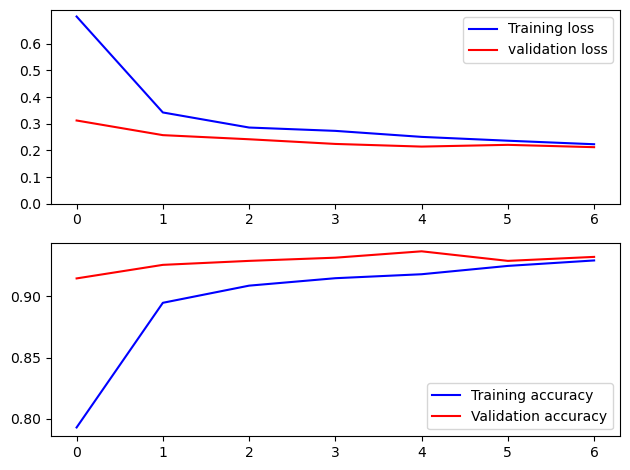

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

## test

In [20]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [21]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\lamaa\AppData\Local\Temp\ipykernel_20212\3470922143.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  93.11 % 


In [22]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [23]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

C:\Users\lamaa\AppData\Local\Temp\ipykernel_20212\727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.96      0.92      0.94       103
  biological       0.94      1.00      0.97        90
 brown-glass       0.96      0.72      0.82        60
   cardboard       0.97      0.90      0.93        93
     clothes       0.98      0.99      0.98       526
 green-glass       0.89      0.88      0.88        65
       metal       0.82      0.88      0.85        80
       paper       0.92      0.89      0.91        91
     plastic       0.81      0.74      0.77        78
       shoes       0.91      0.98      0.95       219
       trash       0.95      0.90      0.93        69
 white-glass       0.83      0.88      0.86        78

    accuracy                           0.93      1552
   macro avg       0.91      0.89      0.90      1552
weighted avg       0.93      0.93      0.93      1552



In [26]:
# model.save('my_model2.hdf5')

## code python for camera

In [ ]:
# from keras.models import load_model
# import tensorflow as tf
# import keras.utils as image
# import keras.applications.mobilenet_v2 as mobilenetv2
# from keras.applications.imagenet_utils import preprocess_input
# import numpy as np
# import cv2
# import time

# label =  {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
#               6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
#               11: 'biological'}
# MODEL_PATH = 'my_model2.hdf5'
# model = load_model(MODEL_PATH)

# def model_predict(img_path):
#     img = image.load_img(img_path, target_size =(224,224))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img,axis=0)
#     img = preprocess_input(img)
#     preds = model.predict(img)
#     y_classes = preds.argmax()
#     result = str(list(label.keys())[list(label.values()).index(y_classes)])

#     return result

# capture_duration = 120
# cam = cv2.VideoCapture(0)
# start_time = time.time()
# font = cv2.FONT_HERSHEY_SIMPLIX
# org = (50,50)
# fontScale = 1
# color = (225,0,0)
# thickness = 2

# while (int(time.time()-start_time) < capture_duration):
#     success,img = cam.read()
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     if success:
#         cv2.imwrite('image.jpg',img)
#         result = model_predict('image.jpg')
#     image1 = cv2.PutText(img,result,org,font,fontScale,color,thickness,cv2.LINE_AA)
#     cv2.imshow('Garbage',image1)
#     if(cv2.waitKey(1)==ord('q')):
#         break
# cam.release()
# cv2.destroyALLWindows()